In [1]:
%run util.py

In [2]:
data_dir = '/home/jzh/Dropbox/Research/Anomaly_Detection/ROCHM/data_dir/'

In [3]:
N = 8
n = 200
beta_1 = 0.2
num_test_sample = 2000

In [4]:
# mu_0: the initial distribution; 1 x (N**2) 
# mu: the actual stationary distribution; 1 x (N**2)
# mu_1: the estimated stationary distribution 
# P: the new transition matrix (the old transition matrix is Q)
# G_1: the estimate of the gradient
# H_1: the estimate of the Hessian
# U_1: an estimated sample path of the Gaussian random vector U; length 1000

# P is the ground truth transition matrix
mu_0, mu, mu_1, P, G_1, H_1, U_1 = ChainGen(N)  

# PP is a different transition matrix for testing purposes
mu_0P, muP, mu_1P, PP, G_1P, H_1P, U_1P = ChainGen(N) 

zdump([N, mu_0, mu, mu_1, P, G_1, H_1, U_1, mu_0P, muP, mu_1P, PP, G_1P, H_1P, U_1P], \
      data_dir + 'P_PP_%d.pkz'%N)

<string>:372: RuntimeWarning: covariance is not positive-semidefinite.


In [5]:
N, mu_0, mu, mu_1, P, G_1, H_1, U_1, mu_0P, muP, mu_1P, PP, G_1P, H_1P, U_1P = zload(data_dir + 'P_PP_%d.pkz'%N)

In [6]:
mu

array([  4.64973457e-02,   4.02641801e-02,   2.74666376e-02,
         8.08487643e-03,   3.36548283e-02,   3.05672807e-03,
         3.92443523e-02,   3.98224657e-05,   1.14362522e-02,
         1.18125980e-02,   1.89293712e-02,   6.75047254e-03,
         3.66594135e-02,   5.89932633e-03,   1.36371826e-03,
         1.46691316e-02,   1.45830825e-02,   1.54029780e-02,
         5.59374040e-03,   8.29145058e-03,   1.79278546e-02,
         3.01531993e-02,   8.65028972e-03,   8.87725102e-03,
         2.49250212e-02,   8.51782448e-03,   2.04063284e-02,
         2.36815962e-02,   2.10317452e-03,   1.81619045e-02,
         3.72989557e-02,   2.35384474e-03,   2.69201189e-02,
         1.08011347e-02,   2.50643389e-02,   2.23918874e-02,
         3.12193351e-02,   1.77050173e-02,   6.03369310e-03,
         5.15835102e-03,   3.32073871e-02,   6.59488294e-03,
         8.87834279e-04,   4.30262580e-02,   2.64358340e-03,
         1.31309285e-02,   8.62201581e-03,   2.44036242e-02,
         2.50464078e-02,

In [7]:
muP

array([  5.52396928e-03,   2.76306650e-02,   1.37234304e-02,
         7.53938687e-03,   9.93033169e-03,   3.18016009e-03,
         2.69153013e-02,   1.71956054e-02,   3.95934370e-02,
         5.01908520e-03,   7.79672679e-03,   1.77410921e-02,
         3.65611336e-02,   2.67461310e-02,   8.26789644e-03,
         9.72618368e-03,   2.83171056e-05,   3.81570698e-02,
         4.44237422e-02,   4.15830693e-03,   2.63131283e-02,
         1.45793455e-02,   1.53265953e-03,   4.41746457e-02,
         5.00153047e-03,   1.82654290e-03,   4.30822161e-02,
         1.16303747e-02,   1.24941332e-02,   7.10263715e-03,
         5.79878023e-03,   2.80633256e-03,   4.98204033e-04,
         2.71695020e-02,   3.34933336e-02,   9.38708922e-03,
         6.45016330e-03,   1.53937564e-02,   3.38642576e-02,
         7.91434351e-03,   1.22477166e-03,   4.08266526e-03,
         5.98508898e-03,   5.26526080e-03,   2.74143419e-02,
         1.47778605e-03,   1.15762886e-02,   1.78076340e-02,
         3.49441991e-02,

In [8]:
eta_wc = {}
eta_Sanov = {}
negative_sample = {}
positive_sample = {}

# Get sample paths of the Markov chain with length n; 
# these paths will be the test set
for idx in range(int(num_test_sample/2)):
    negative_sample[idx] = chain(mu, P, n)
for idx in range(int(num_test_sample/2)):
    positive_sample[idx] = chain(muP, PP, n)
    
# Get thresholds for Hoeffding's test corresponding to sample length n    
key = str(n) + '_' + str(beta_1)
eta_1 = ThresWeakConv(N, beta_1, n, mu_0, mu, mu_1, P, G_1, H_1, U_1).ThresCal()
eta_2 = ThresSanov(N, beta_1, n, mu_0, mu, mu_1, P, G_1, H_1, U_1).ThresCal()
eta_wc[key] = eta_1
eta_Sanov[key] = eta_2

zdump([negative_sample, positive_sample, eta_wc, eta_Sanov], data_dir + 'testSample_threshold_%d.pkz'%N)

In [9]:
negative_sample, positive_sample, eta_wc, eta_Sanov = zload(data_dir + 'testSample_threshold_%d.pkz'%N)

In [10]:
len(negative_sample[0]), eta_wc, eta_Sanov

(200, {'200_0.2': 0.16283362296135748}, {'200_0.2': 0.0080471895621705})

In [11]:
from __future__ import division

mu = np.reshape(mu, (N, N))

key = str(n) + '_' + str(beta_1)

negative_sample_KL = {}
positive_sample_KL = {}

negative_sample_wc = {}
negative_sample_sv = {}

positive_sample_wc = {}
positive_sample_sv = {}

for idx in range(int(num_test_sample/2)):
    negative_sample_KL[idx] = KL_est(negative_sample[idx], mu)
    if negative_sample_KL[idx] > eta_wc[key]:
        negative_sample_wc[idx] = 1
    else:
        negative_sample_wc[idx] = -1
    if negative_sample_KL[idx] > eta_Sanov[key]:
        negative_sample_sv[idx] = 1
    else:
        negative_sample_sv[idx] = -1    
    
    
for idx in range(int(num_test_sample/2)):
    positive_sample_KL[idx] = KL_est(positive_sample[idx], mu)
    if positive_sample_KL[idx] > eta_wc[key]:
        positive_sample_wc[idx] = 1
    else:
        positive_sample_wc[idx] = -1
    if positive_sample_KL[idx] > eta_Sanov[key]:
        positive_sample_sv[idx] = 1
    else:
        positive_sample_sv[idx] = -1 

In [12]:
def count_one(x):
    s = 0
    for idx in range(len(x)):
        if x[idx] == 1:
            s += 1
    return s, len(x) - s

In [13]:
positive_sample_len_list = [int(num_test_sample/2)]

TPR_wc = []

for real_pos in positive_sample_len_list:
    x = [positive_sample_wc[idx] for idx in range(real_pos)]
    s, _ = count_one(x)
    TPR_wc.append(s / real_pos)
    
# TPR_wc.append(0)
# TPR_wc.append(1)

TPR_wc = list(set(TPR_wc))

TPR_wc.sort()
TPR_wc

[1.0]

In [14]:
negative_sample_len_list = [int(num_test_sample/2)]

FPR_wc = []

for real_neg in negative_sample_len_list:
    x = [negative_sample_wc[idx] for idx in range(real_neg)]
    s, _ = count_one(x)
    FPR_wc.append(s / real_neg)

# FPR_wc.append(0)
# FPR_wc.append(1)

FPR_wc = list(set(FPR_wc))

FPR_wc.sort()
FPR_wc

[0.232]

In [15]:
range(100, 1100, 100)

[100, 200, 300, 400, 500, 600, 700, 800, 900, 1000]

In [16]:
positive_sample_len_list = [int(num_test_sample/2)]

TPR_sv = []

for real_pos in positive_sample_len_list:
    x = [positive_sample_sv[idx] for idx in range(real_pos)]
    s, _ = count_one(x)
    TPR_sv.append(s / real_pos)

# TPR_sv.append(0)
# TPR_sv.append(1)

TPR_sv = list(set(TPR_sv))

TPR_sv.sort()
TPR_sv

[1.0]

In [17]:
negative_sample_len_list = [int(num_test_sample/2)]

FPR_sv = []

for real_neg in negative_sample_len_list:
    x = [negative_sample_sv[idx] for idx in range(real_neg)]
    s, _ = count_one(x)
    FPR_sv.append(s / real_neg)

# FPR_sv.append(0)
# FPR_sv.append(1)

FPR_sv = list(set(FPR_sv))

FPR_sv.sort()
FPR_sv

[1.0]

In [18]:
if len(TPR_sv) < len(FPR_sv):
    TPR_sv_ext = TPR_sv + [TPR_sv[-1]] * (len(FPR_sv) - len(TPR_sv))
else:
    TPR_sv_ext = TPR_sv[0:len(FPR_sv)]

In [19]:
if len(TPR_wc) < len(FPR_wc):
    TPR_wc_ext = TPR_wc + [TPR_wc[-1]] * (len(FPR_wc) - len(TPR_wc))
else:
    TPR_wc_ext = TPR_wc[0:len(FPR_wc)]

In [20]:
roc_sv_pts = [(s, t) for s, t in zip(FPR_sv, TPR_sv_ext)]

In [21]:
roc_wc_pts = [(s, t) for s, t in zip(FPR_wc, TPR_wc_ext)]

In [22]:
len(FPR_wc), len(TPR_wc_ext), len(roc_wc_pts)

(1, 1, 1)

In [23]:
roc_sv_pts, roc_wc_pts

([(1.0, 1.0)], [(0.232, 1.0)])

/home/jzh/anaconda2/lib/python2.7/site-packages/matplotlib/font_manager.py:1288: UserWarning: findfont: Font family [u'normal'] not found. Falling back to Bitstream Vera Sans
  (prop.get_family(), self.defaultFamily[fontext]))


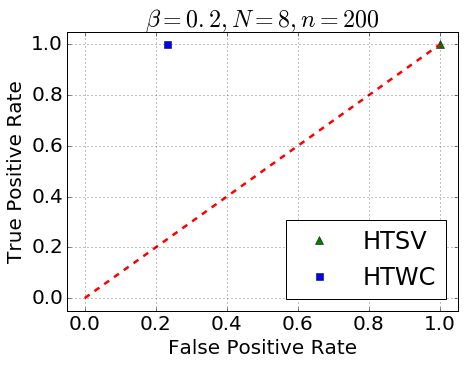

In [24]:
import matplotlib.pyplot as plt
import pylab
from pylab import *
%matplotlib inline  
import itertools 


plt.figure(figsize=(7, 5))

font = {'family' : 'normal',
        'weight' : 'normal',
        'size'   : 20}

matplotlib.rc('font', **font)

roc_sv, = plt.plot([roc_sv_pts[idx][0] for idx in range(len(roc_sv_pts))], \
                   [roc_sv_pts[idx][1] for idx in range(len(roc_sv_pts))], "g^", linewidth=3.5, \
                   markersize=8)
roc_wc, = plt.plot([roc_wc_pts[idx][0] for idx in range(len(roc_wc_pts))], \
                   [roc_wc_pts[idx][1] for idx in range(len(roc_wc_pts))], "bs", linewidth=3.5, \
                   markersize=7)

plt.plot([0, 1], [0, 1], "r--", linewidth=2.5)

plt.legend([roc_sv, roc_wc], [r"HTSV", r"HTWC"], loc=4, numpoints=1)
plt.title(r"$\beta = %s, N = %s, n = %s$"%(beta_1, N, n))
# plt.xticks(N_list)

pylab.xlim(-0.05, 1.05)
pylab.ylim(-0.05, 1.05)

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.grid()


savefig(data_dir + 'ROC_N_%s_n_%s.eps'%(N, n))

plt.show()